In [1]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_classes = 4

# Resnet model
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

model.load_state_dict(torch.load('best_model_1.pth'))
model.eval();

cpu


C:\Users\HansW\mitwworkspace\MakeAIWork2\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HansW\mitwworkspace\MakeAIWork2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
image_size = 224
batch_size = 8

test_dir = "../data/Test"

# Define the transformations for test data before entering the neural network
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),                     # Resize images to 224x224 pixels
    transforms.ToTensor(),                                           # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

# Load the test dataset
test_dataset = ImageFolder(test_dir, transform=transform_test)

test_dataset.class_to_idx
idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}
idx2class


# Create DataLoaders for managing the data batches
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def test(model, criterion, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    accuracy = 100.0 * correct / total
    return running_loss / len(test_loader), accuracy



In [3]:
# !python -m torch.utils.collect_env

In [4]:
criterion = nn.CrossEntropyLoss()

test_loss, test_accuracy = test(model, criterion, test_loader, device)

In [5]:
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.6384, Test Accuracy: 77.50%


cpu
[[25  1  0  4]
 [ 6 17  1  0]
 [ 2  3 31  2]
 [ 1  6  1 20]]


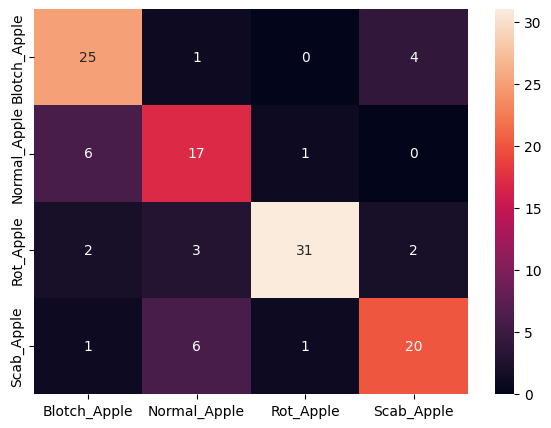

In [6]:


print(device)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs) # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    # output=output.to(device)
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    # labels=labels.to(device)
    y_true.extend(labels) # Save Truth


# # constant for classes
classes = ('0','1','2','3')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax);

